## Distributed Conditional GAN (discGAN)
### GANs with and without distribution
#### Diana and David

**This notebook contains the discGAN code that our team put together along with several implementations of it.**

**The code generalizes tabular output for the conditional GAN and allows for distribution.**

In [1]:
# import packages

import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import layers

from torch import optim
from torch.nn import BatchNorm1d, Linear, ReLU, Sequential, functional, Module


import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools
import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
import joblib

pd.set_option('display.max_rows', None)

In [2]:
!pip install table_evaluator # install table evaluator

#https://pypi.org/project/table-evaluator/
# used to evaluate the performance of the tabular data generation vs the true data

from table_evaluator import load_data, TableEvaluator # import functions

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
# if connecting to Colab, connect to Google Drive with this code:

#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
class Residual(Module):
    """Residual layer for the CTGANSynthesizer."""

    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input_):
        """Apply the Residual layer to the `input_`."""
        out = self.fc(input_)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input_], dim=1)

## Create the cGAN class along with some important functions to be used throughout the notebook:

In [5]:
# the skeleton of this code is derived from the following tutorial:
# https://keras.io/examples/generative/conditional_gan/#interpolating-between-classes-with-the-trained-generator

# info on distributing across GPUs: https://www.tensorflow.org/tutorials/distribute/custom_training

# create the conditional GAN

class ConditionalGAN(keras.Model):
    def __init__(self, noise_dim=50, 
                 data_shape=1,
                 num_classes=3, 
                 d_learning_rate=1e-5, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = False, distribute = False): # distributed flag can be 'G', 'D', or 'both' for distributing the generator, discriminator, or both

        super(ConditionalGAN, self).__init__()
        self.noise_dim = noise_dim
        self.data_shape = data_shape # output shape of the generator and goes to discriminator
        self.num_classes = num_classes # number of classes across the categorical features
        self.d_optimizer = tf.keras.optimizers.Adam(d_learning_rate)
        self.g_optimizer = tf.keras.optimizers.Adam(g_learning_rate)
        self.batch_size = batch_size
        self.start_epoch = start_epoch
        self.verbose = verbose
        self.distribute = distribute

        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

        # add number of class labels to the input channels for generator
        self.g_dim = self.noise_dim + self.num_classes

        # add the number of class labels to the input to the discriminator
        self.d_dim = self.data_shape + self.num_classes

        if (self.verbose):
            print("Generator input dim: ", self.g_dim)
            print("Dicrimination input dim: ", self.d_dim)

        # build generator and discriminator
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def build_generator(self):
        "Build the generator model"
        inputs = Input(shape=(self.g_dim,))
        hidden = Dense(64)(inputs) # 128
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dense(64)(hidden)
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = BatchNormalization()(hidden) # added 
        hidden = Dense(64)(hidden)
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = BatchNormalization()(hidden) # added 
        hidden = Dense(64)(hidden) # added 
        hidden = LeakyReLU(alpha=0.2)(hidden)
        
        output = Dense(self.data_shape, activation="sigmoid")(hidden)
        #output = Dense(self.data_shape, activation="linear")(hidden)
        
        '''
        dim = self.noise_dim
        seq = []
        for item in list((self.g_dim, )):
            seq += [Residual(dim, item)]
            dim += item
        seq.append(Linear(dim, self.data_shape))
        self.seq = Sequential(*seq)
        output = self.seq(tf.convert_to_tensor(inputs))
        '''
        
        
        
        # add the ability to distribute the generator
        
        if self.distribute == False: 
          generator = Model(inputs=inputs, outputs=output, name="generator")

        elif self.distribute == 'G' or self.distribute.lower() == 'both':
          mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() #tf.distribute.MirroredStrategy()
          with mirrored_strategy.scope():

            generator = Model(inputs=inputs, outputs=output, name="generator")
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
            
        else:
            print('Unrecognized distribution call. Reverting to non distributed GAN.')
            generator = Model(inputs=inputs, outputs=output, name="generator")

        generator.summary()
        return generator


    def build_discriminator(self):
        "build the discriminator model"
        d_inputs = Input(shape=(self.d_dim,))
        h = Dense(64, input_shape=(self.g_dim,))(d_inputs) 
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(64)(h) #32
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(1, activation="sigmoid")(h)
        
        # add the ability to distribute the discriminator
        
        if self.distribute == False:
          discriminator = Model(d_inputs, h, name="discriminator")

        elif self.distribute == 'D' or self.distribute.lower() == 'both':
          mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() #tf.distribute.MirroredStrategy()
          with mirrored_strategy.scope():
            discriminator = Model(d_inputs, h, name="discriminator")
            print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))
            
        else:
            print('Unrecognized distribution call. Reverting to non distributed GAN.')
            discriminator = Model(inputs=inputs, outputs=output, name="generator")      

        discriminator.summary()
        return discriminator

    def compile(self, loss_fn):
        super(ConditionalGAN, self).compile()
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_ages, one_hot_labels = data
        real_ages = tf.cast(real_ages, tf.float32)
        #print("real_ages:", real_ages[0:2])

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the true data. This is for the discriminator.
        one_hot_labels = one_hot_labels[:, None]
        print("one_hot_labels1:", one_hot_labels[0:2])

        one_hot_labels = tf.repeat(one_hot_labels, repeats=[1])
        print("one_hot_labels2:", one_hot_labels[0:2])

        one_hot_labels = tf.reshape(one_hot_labels, (-1, self.num_classes))
        one_hot_labels = tf.cast(one_hot_labels, tf.float32)
        print("one_hot_labels3:", one_hot_labels[0:2])

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_ages)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake.
        generated_continuous = self.generator(random_vector_labels)
        generated_continuous= tf.cast(generated_continuous, tf.float32)

        # combine generated output and truth
        fake_ages_and_labels = tf.concat([generated_continuous, one_hot_labels], -1)
        real_ages_and_labels = tf.concat([real_ages, one_hot_labels], -1) 
        combined_ages = tf.concat([fake_ages_and_labels, real_ages_and_labels], axis=0)

        # Assemble labels discriminating real from fake. 1 == fake, 0 == real
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        #labels = tf.random.shuffle(labels, seed = 24)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_ages)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.t
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_ages = self.generator(random_vector_labels)
            fake_ages_and_labels = tf.concat([fake_ages, one_hot_labels], -1)
            predictions = self.discriminator(fake_ages_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
    
    #######################
    
    ## function graveyard
    
    # this function creates a list of arrays with every possible position of one 1 and remaining 0s
    '''
    def create_zeros(size):
        
      a = []

      for i in range(size):
        b = [0] * size
        b[i] = 1
        a.append(b)
      return a
      '''


    '''def generate(self, n=1000, one_hot_label=[1., 0., 0., 0., 0., 0., 1., 0.]):
        """Generate n ages for a class"""
        print("Generating: ", n, " ages for unit type: ", one_hot_label)
        input_noise = tf.random.normal((n, self.noise_dim), 0, 1)
        random_vector_labels = tf.concat([input_noise, one_hot_label], axis=1)

        ages = self.generator(random_vector_labels)

        return ages.numpy()'''
    
    

## Function used to generate data and display statistics on the generated output:

In [6]:
def generate_table(df, mod, features = ['ethnicity', 'gender'], cont_feats = ['age'], n = None, print_out = True): # n is number of values to generate; if None, then the count for each category in the true data is produced
    
  i = 0 # iterator 
  l = [] 

  encoder = OneHotEncoder(handle_unknown='ignore', categories = 'auto') # OHE sklearn initiate
  encoder.fit_transform(df_feats[features]).toarray()
    
  encoder_df = pd.DataFrame(encoder.fit_transform(df_feats[features]).toarray(), columns = encoder.get_feature_names(features))

  # merge one-hot encoded columns back with original DataFrame
  final_df = df_feats.join(encoder_df)

  for j in np.unique(encoder.fit_transform(df_feats[features]).toarray(), axis=0): # iterate through the possible combos of OHE labels


    """Generate n elements for a class"""
    print('_'*30)
    
    print('Categorical features:', features)
    
    if print_out:
        if n != None:
            print("Generating: ", n, " data elements with categorical vars: ", 
                  df.groupby(features).count().iloc[i].name)

        else:
            print("Generating: ", df.groupby(features).count().iloc[i][0], " data elements with categorical vars: ", 
                  df.groupby(features).count().iloc[i].name)
    
    if n == None:
        one_hot_labels = tf.repeat([j],df.groupby(features).count().iloc[i][0], axis=0)
        input_noise = tf.random.normal((df.groupby(features).count().iloc[i][0], mod.noise_dim), 0, 1)
        
    else:
        one_hot_labels = tf.repeat([j],n, axis=0)
        input_noise = tf.random.normal((n, mod.noise_dim), 0, 1)
        
    random_vector_labels = tf.concat([input_noise, tf.cast(one_hot_labels, dtype=tf.float32)], axis=1)
    
    gen_data = mod.generator(random_vector_labels) # call the generator from cgan

    f_dict = {} # dictionary to hold info cat vars
    for m in range(len(features)):
      f_dict[m] = df.groupby(features).count().iloc[i].name[m] # number of examples of each feature in the true data


    # create query to specify each possibility of cat combonations
    q = ''
    for m in range(len(features)):
      q += features[m] + " == '" + f_dict[m] +"' &"
    q = q[:-1]

    df_feats_class = final_df.query(q)

    df_temp = pd.DataFrame(columns = cont_feats + features)

    di_cont = {} # dictionary to hold continuous vars

    if i == 0:
      df_age_eth = pd.DataFrame(columns = cont_feats + features)

    k = 0
    for c in cont_feats:

      print(' ')
    
      if n == None:
    
         input_noise = tf.random.normal((df.groupby(features).count().iloc[i][0], mod.noise_dim), 0, 1)
        
      else:
        
         input_noise = tf.random.normal((n, mod.noise_dim), 0, 1)
      
      random_vector_labels = tf.concat([input_noise, tf.cast(one_hot_labels, dtype=tf.float32)], axis=1)
      
      gen_data = mod.generator(random_vector_labels)
        
      # scale data  

      mean_filtered = df[c].mean()
      std_filtered =  df[c].std()
      min_filtered =  df[c].min()
      max_filtered =  df[c].max()

      scaled_filtered = [(x - min_filtered)/(max_filtered - min_filtered) for x in df[c]]
      scaled_filtered = [0 if math.isnan(x) else x for x in scaled_filtered]
      all = np.reshape(scaled_filtered, (-1, 1))
      di_cont[k] = all
      inv_gen_ages = [(val * (max_filtered-min_filtered)) + min_filtered for val in gen_data.numpy().flatten()]
      df_temp[c] = inv_gen_ages
    
      # show some stats for the generated and real data
      if print_out:
          print("Generated statistics for continuous var <", c, ">:")
          print("min: ", np.min(inv_gen_ages))
          print("mean: ", np.mean(inv_gen_ages))
          print("max: ", np.max(inv_gen_ages))
          print("stdv: ", np.std(inv_gen_ages))
          print(' ')

          print("Statistics of real data for continuous var <", c, ">:")
          print("min: ", np.min(df_feats_class[c]))
          print("mean: ", np.mean(df_feats_class[c]))
          print("max: ", np.max(df_feats_class[c]))
          print("stdv: ", np.std(df_feats_class[c]))
      k += 1

    for f in range(len(features)): # add in the generated categorical data for each generated data
      df_temp[features[f]] = f_dict[f]

    df_age_eth = df_age_eth.append(df_temp) # append the generated tabular data
    i+=1
    print(' ')

  return df_age_eth, final_df


## Data Prep: Create TF Dataset

In [7]:
cont_feats = ['hospitaldischargeoffset']#, 'age'] # continuous features

In [8]:
#features = [i for i in df.columns if i not in ['age' + cont_feats]]#['pasthistoryvalue', 'ethnicity', 'gender', 'hospitaldischargestatus'] # categorical features

In [9]:
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('/sfs/qumulo/qhome/dmf4ns/DS6050/patients_cardiorepiratory_textcats.csv')

features = [i for i in df.columns if i not in ['age'] + cont_feats]

for f in features:
    df[f] = df[f].astype(str)

feats_np = df[cont_feats + features].to_numpy()
print('length: ', len(feats_np))
print(feats_np[0:5])


# create a dictionary of feature arrays for all features we will generate

di_f = {}
i = 0
for f in cont_feats + features:
  di_f[i] = np.asarray(feats_np[:,i].flatten().tolist()).flatten()
  i += 1

# create DF from the arrays above. These are the true data from which we will create synthetic data
    
df_feats = pd.DataFrame(zip(*di_f.values()), columns=cont_feats + features)
print(df_feats.shape)
#print(df_feats.groupby(features).count())

# create data set
print("==" * 30)
print("Data Info:")

try:
  df_feats_filtered = df_feats.query("age < 90") # filter for only age <90 if age is the cont var

except:
  df_feats_filtered = df_feats

for i in features:
  df_feats_filtered[i+'_code'] = df_feats_filtered[i].astype('category').cat.codes # set up dummy DF columns

#print(df_feats_filtered.groupby(features[0]).count())

di_cont = {}
i = 0

for c in cont_feats: # print stats for each continues variable and save for standardizing
  mean_filtered = df_feats_filtered[c].mean()
  std_filtered =  df_feats_filtered[c].std()
  min_filtered =  df_feats_filtered[c].min()
  max_filtered =  df_feats_filtered[c].max()

  print("mean age: ", mean_filtered)
  print("std age: ", np.round(std_filtered,3))
  print("min age: ", min_filtered)
  print("max age: ", max_filtered)
    
  # standardize

  scaled_filtered = [(x - min_filtered)/(max_filtered - min_filtered) for x in df_feats_filtered[c]]
  scaled_filtered = [0 if math.isnan(x) else x for x in scaled_filtered] # replace missing with 0 (the mean)
  all = np.reshape(scaled_filtered, (-1, 1))
  di_cont[i] = all
  i+=1

# dictionary for cat vars
di = {}
i = 0
for f in features: # dummy encode the categorical features
  di[i] = keras.utils.to_categorical(df_feats_filtered[f + '_code'], df_feats_filtered[f + '_code'].max()+1)
  i += 1

all = np.concatenate(list(di_cont.values()), axis = 1) # concat the continuous variable arrays
all_labels = np.concatenate(list(di.values()), axis = 1) # concat the categoritcal variable arrays

print(f"Shape of continuous var(s): {all.shape}")

print(f"Shape of labels: {all_labels.shape}")

# Create tf.data.Dataset.

dataset = tf.data.Dataset.from_tensor_slices((all, all_labels))
dataset = dataset.shuffle(buffer_size=200).batch(64)


length:  2027
[[2616 '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' 'Caucasian' 'Female'
  'Alive']
 [1218 '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' 'Caucasian' 'Male' 'Alive']
 [1138 '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' 'Caucasian' 'Female'
  'Alive']
 [5263 '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' 'Caucasian' 'Male' 'Alive']
 [1086 '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' 'Caucasian' 'Female'
  'Alive']]
(2027, 14)
Data Info:
mean age:  8310.858904785397
std age:  9528.791
min age:  43
max age:  143016
Shape of continuous var(s): (2027, 1)
Shape of labels: (2027, 43)


2022-04-27 00:20:27.274172: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 00:20:30.535719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10771 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7
2022-04-27 00:20:30.541016: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10788 MB memory:  -> device: 1, name: Tesla K80, pci bus id: 0000:06:00.0, compute capability: 3.7
2022-04-27 00:20:30.542518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 10788 MB m

______
## Set up discGAN and run on dataset created above; distribute the discriminator

In [10]:
cgan = ConditionalGAN(noise_dim=50,
                 data_shape=len(cont_feats),
                 num_classes=all_labels[:1].shape[1], 
                 d_learning_rate=1e-6, 
                 g_learning_rate=1e-6, 
                 batch_size = 32, 
                 start_epoch=0,
                 verbose = True)#, distribute = 'D')

discgan = ConditionalGAN(noise_dim=50,
                 data_shape=len(cont_feats),
                 num_classes=all_labels[:1].shape[1], 
                 d_learning_rate=1e-6, 
                 g_learning_rate=1e-6, 
                 batch_size = 32, 
                 start_epoch=0,
                 verbose = True, distribute = 'D')

Generator input dim:  93
Dicrimination input dim:  44
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44)]              0         
                                                                 
 dense (Dense)               (None, 64)                2880      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 

In [11]:
cgan.compile(loss_fn=tf.keras.losses.BinaryCrossentropy())
discgan.compile(loss_fn=tf.keras.losses.BinaryCrossentropy())

In [ ]:
for e in [15000, 20000, 25000]:

    checkpoint_path = "DS6050/training_" + str(e) +"/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1, save_freq=10*32)

    cgan.fit(dataset, epochs=e, verbose=False, callbacks=[cp_callback])#, shuffle = True)

    df_age_eth, final_df = generate_table(df_feats, mod = cgan, features = features, cont_feats = cont_feats, print_out = False)
    df_age_eth['data'] = 'GAN'
    final_df['data'] = 'Truth'
    df_true = final_df[cont_feats + features]
    df_all = final_df[cont_feats + features + ['data']].append(df_age_eth).reset_index(level = 0).drop('index', axis = 1)
    df_all.to_csv('no_dist_output/gen_discharge_data_' + str(e) + '.csv')
    
 
    df_age_eth, final_df = generate_table(df_feats, mod = cgan, features = features, cont_feats = cont_feats, n = 500, print_out = False)
    df_age_eth['data'] = 'GAN'
    final_df['data'] = 'Truth'
    #df_true = final_df[cont_feats + features]
    df_all = final_df[cont_feats + features + ['data']].append(df_age_eth).reset_index(level = 0).drop('index', axis = 1)
    df_all.to_csv('no_dist_output/gen_discharge_data_' + str(e) + '_500samples.csv')

In [12]:
for e in [15000, 20000, 25000]:

    checkpoint_path = "DS6050/dist_training_" + str(e) +"/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1, save_freq=10*32)

    discgan.fit(dataset, epochs=e, verbose=False, callbacks=[cp_callback])#, shuffle = True)

    df_age_eth, final_df = generate_table(df_feats, mod = discgan, features = features, cont_feats = cont_feats)
    df_age_eth['data'] = 'GAN'
    final_df['data'] = 'Truth'
    df_true = final_df[cont_feats + features]
    df_all = final_df[cont_feats + features + ['data']].append(df_age_eth).reset_index(level = 0).drop('index', axis = 1)
    df_all.to_csv('dist_output/disc_discharge_data_' + str(e) + '.csv')
    
    
    df_age_eth, final_df = generate_table(df_feats, mod = discgan, features = features, cont_feats = cont_feats, n = 500)
    df_age_eth['data'] = 'GAN'
    final_df['data'] = 'Truth'
    #df_true = final_df[cont_feats + features]
    df_all = final_df[cont_feats + features + ['data']].append(df_age_eth).reset_index(level = 0).drop('index', axis = 1)
    df_all.to_csv('dist_output/disc_discharge_data_' + str(e) + '_500samples.csv')

one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 43), dtype=float32)
one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 43), dtype=float32)
one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 43), dtype=float32)
one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 43), dtype=float32)

Epoch 10: saving model to DS6050/dist_training_15000/cp.ckpt

Epoch 20: saving model to DS6050/dist_training_15000/cp.ckpt

Epoch 30: saving model to DS6050/dist_training_15000/cp.ckpt

Epoch 40: saving model to DS6050/dist_training_15000/cp.ckpt

Epoch 50: saving model to DS6050/dist_training_15000/cp.ckpt

Epoch 60: saving model to DS6050/dist_training_15000/cp.ckpt

Epoch 70: saving model to DS6050/dist_training_15000/cp.ckpt

Epoch 80: saving model to DS6050/dist_training_15000/cp.ckpt

Epoch 90: saving model to DS6050/di

### Generate data and evaluate synthetic output

**Evaluate output data**

In [13]:
table_evaluator = TableEvaluator(df_all[df_all['data'] == 'Truth'][cont_feats + features], df_all[df_all['data'] == 'GAN'][cont_feats + features], cat_cols=features)

In [14]:
table_evaluator.evaluate(target_col=features[0])


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.6724   0.7340              0.5235
DecisionTreeClassifier_real   0.8177   0.6847              0.5149
LogisticRegression_fake       0.7044   0.7069              0.9106
LogisticRegression_real       0.8670   0.8793              0.9661
MLPClassifier_fake            0.6502   0.7044              0.6708
MLPClassifier_real            0.8202   0.8670              0.8085
RandomForestClassifier_fake   0.7463   0.8227              0.6338
RandomForestClassifier_real   0.8399   0.7291              0.5467

Privacy results:
                                         result
Duplicate rows between sets (real/fake)  (4, 0)
nearest neighbor mean                    0.9211
nearest neighbor std                     0.5363

Miscellaneous results:
                                  Result
Column Cor

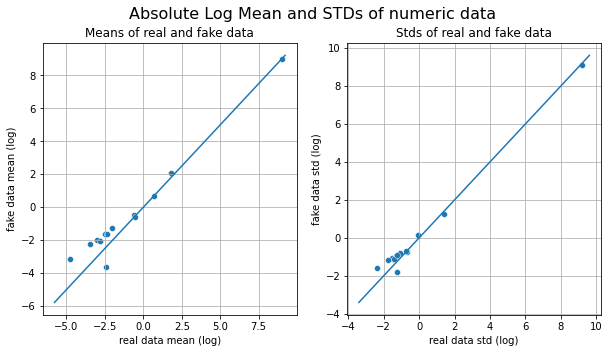

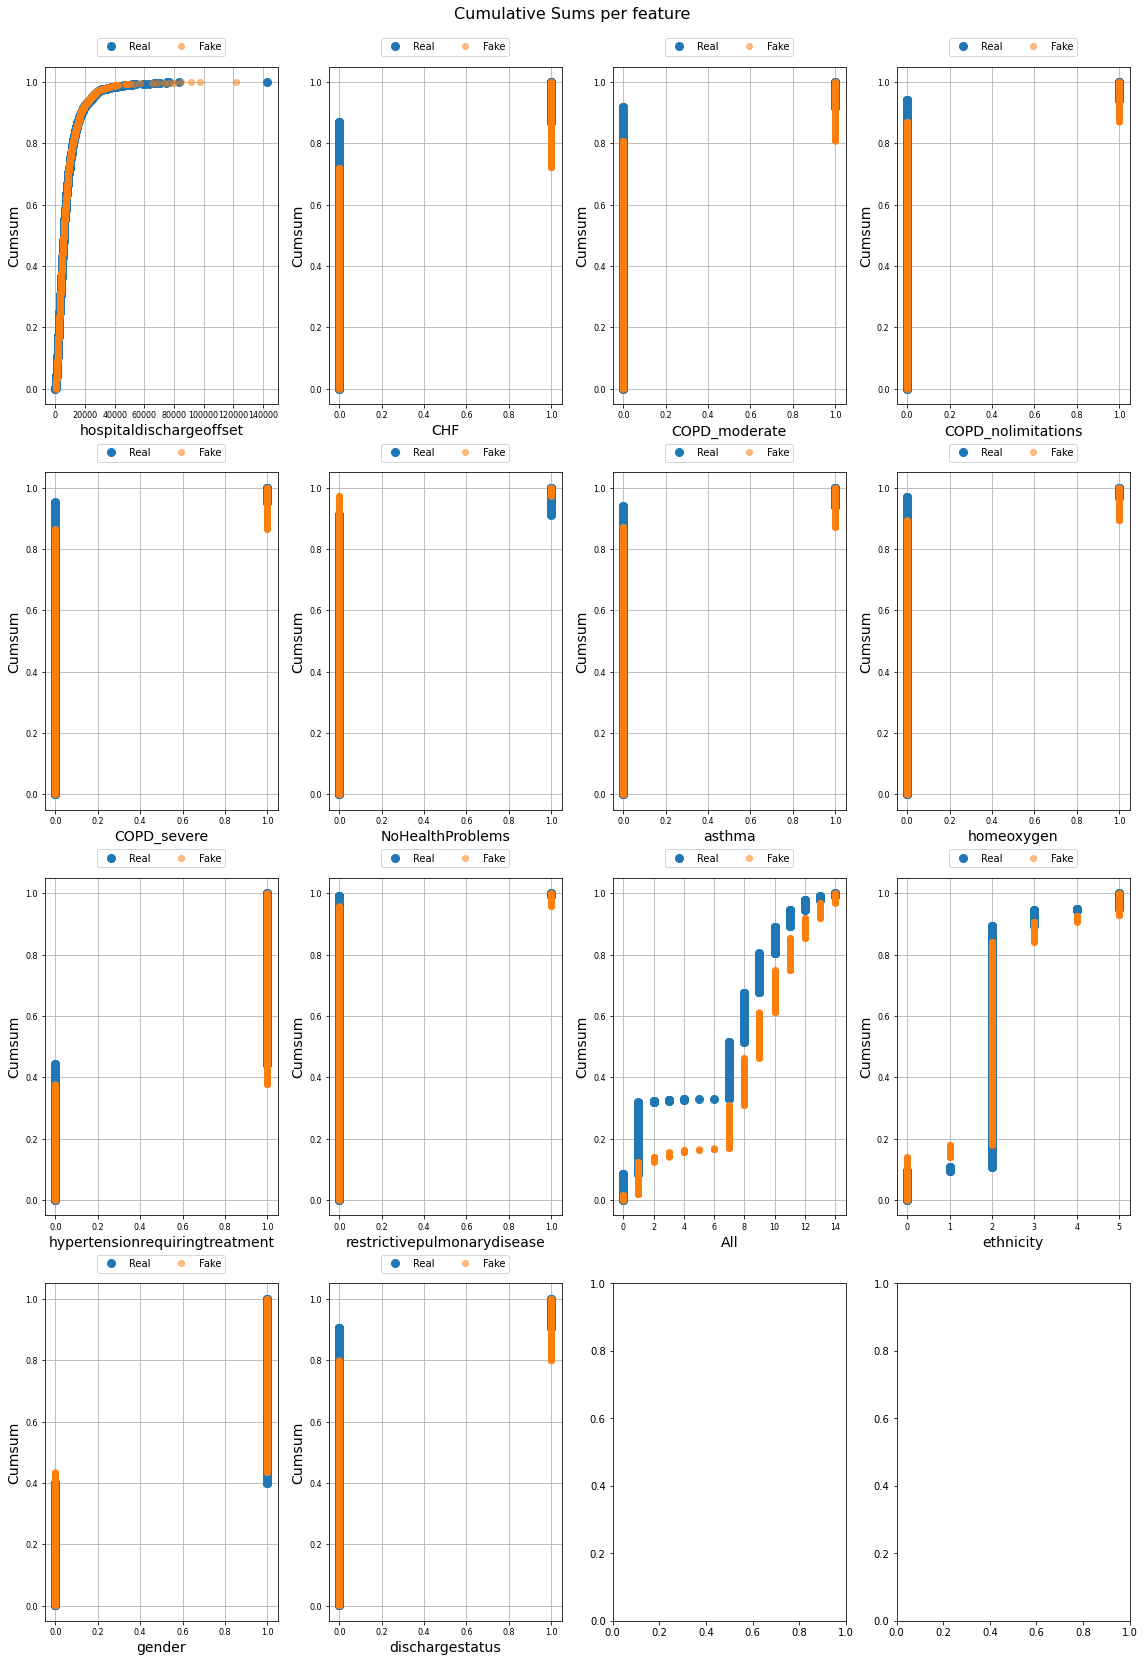

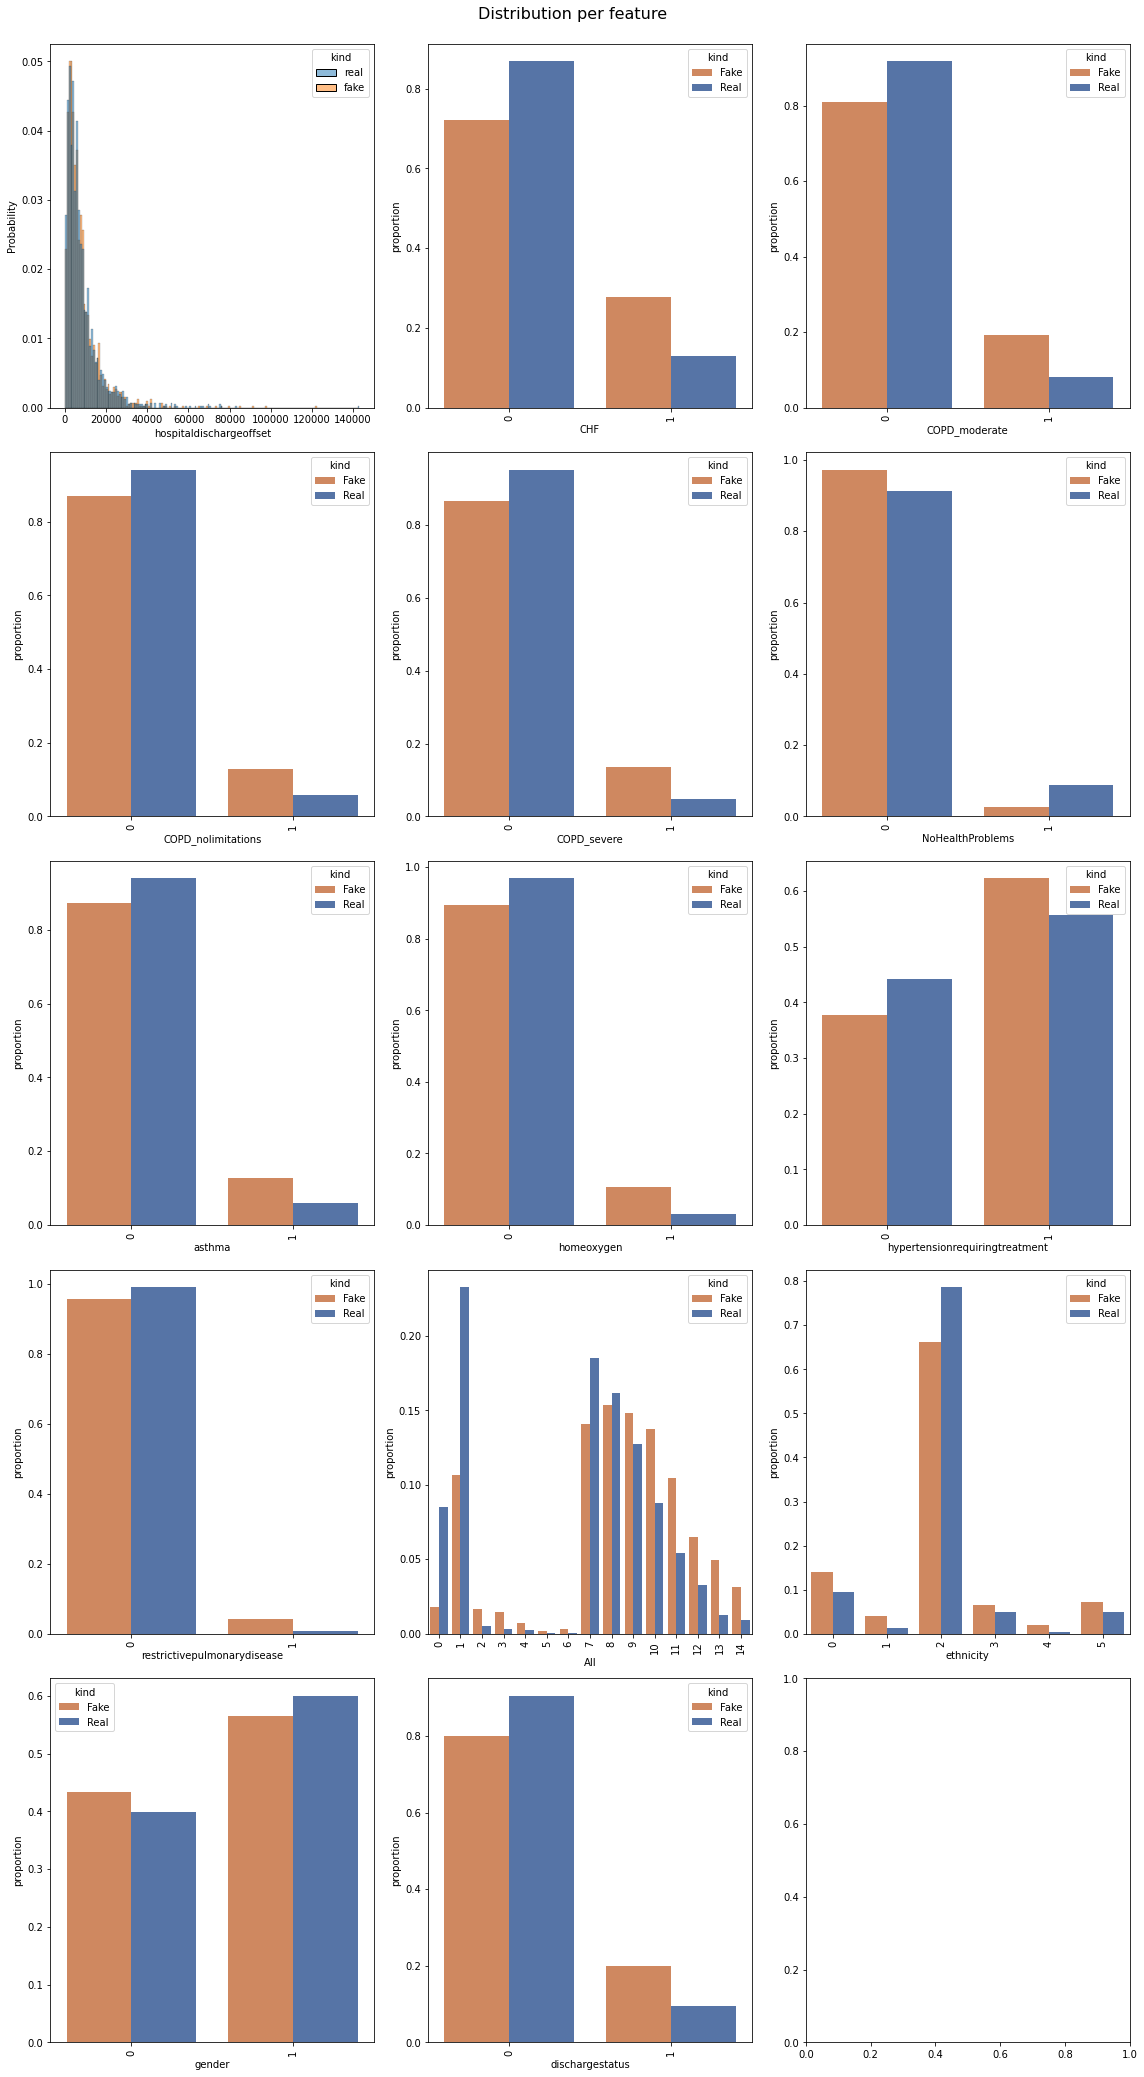

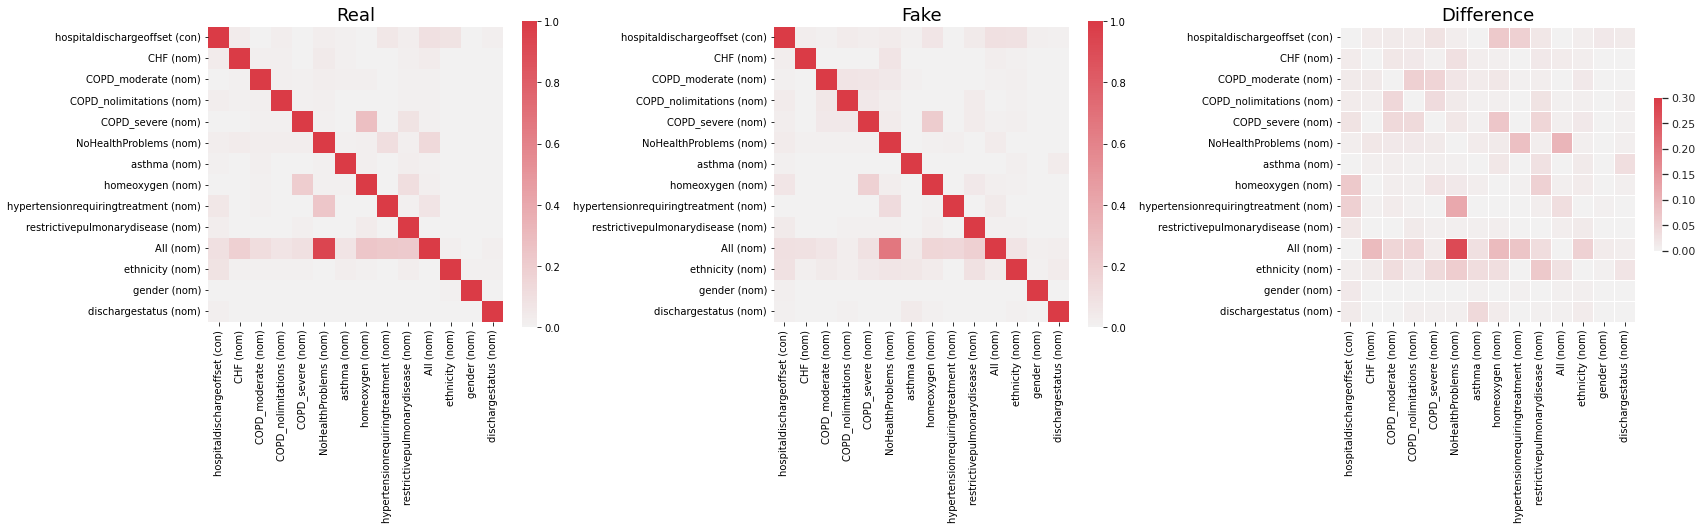

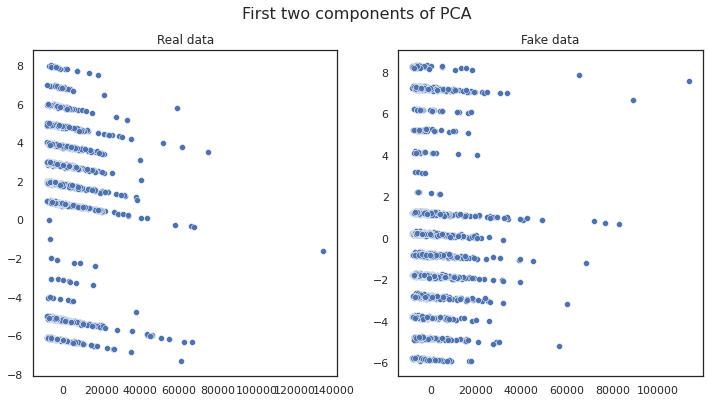

In [15]:
table_evaluator.visual_evaluation()